In [1]:
!pip install openai
!pip install tiktoken
!pip install spacy
!pip install gensim
!pip install nltk

!python -m spacy download it_core_news_sm

!wget -O unk.csv "UNK"
# to remove the output of the installation
from IPython.display import clear_output
clear_output(wait=True)
print('Set up complete')

Set up complete


In [2]:
import re
import openai
import pandas as pd
import spacy
import tiktoken
from scipy import spatial

# Load the Italian language model
nlp = spacy.load('it_core_news_sm')

import gensim
import nltk
from gensim import corpora

nltk.download('stopwords')
it_stop = set(nltk.corpus.stopwords.words('italian'))
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')

In [3]:
df = pd.read_csv("unk.csv").iloc[:, 1:]
df.head(3)

,ID,Testo,Data,Categorie,Allegato,CNC,Sorgente,Canale,Risposta,CleanText,level_1,level_2,level_3,level_4
0,4935171453181261_5071482946216777,Per piacere: il prezzo della scatola di “divin...,2022-01-07 09:59:00,SALES & DISTRIBUTION -> PREZZO -> INFO (FB01),NaN,caring,NaN,NaN,"Ciao {customer_name}, il prezzo di ogni confez...",Per piacere: il prezzo della scatola di “divin...,SALES & DISTRIBUTION,PREZZO,INFO (FB01),NaN
1,4486011984763879_5010103639021375,Quando un cliente invia una email è cortesia r...,2021-12-21 10:27:00,no_cat,NaN,caring,NaN,NaN,"Ciao Edoardo, ci dispiace per quanto ci hai se...",Quando un cliente invia una email è cortesia r...,no_cat,NaN,NaN,NaN
2,5090655194299552_5118963101468761,"Salve, avete caffè in chicchi?",2022-01-19 21:30:00,SALES & DISTRIBUTION -> VENDITA DIRETTA (E-COM...,NaN,caring,NaN,NaN,"Ciao Massimo, puoi trovare la nostra selezione...",Salve avete caffè in chicchi?,SALES & DISTRIBUTION,VENDITA DIRETTA (E-COMMERCE/TELEFONO),INFO ASSORTIMENTO PRODOTTI FOOD (FD19),NaN


# **Data Exploration**

In [164]:
df.iloc[172].Testo, df.iloc[172].Risposta

('Vorrei sapere per favore se esistono ancora le capsule per la macchinetta  espresso e cappuccino grazie',
 'Ciao {customer_name}, riesci a darci qualche informazione aggiuntiva sui prodotti a cui sei interessata? Scrivici i dettagli e ti aiuteremo al più presto. Buona giornata!')

In [165]:
df.iloc[420].Testo

"Antonio Semprevivo  compatibili con nespresso????? L'offerta è ancora valida ?"

In [166]:
df.iloc[937].Testo

'Carmen Ronchi bravo e quello che successo a me sotto Natale o preso anche x fare dei regali e x fortuna che mi serviva anche x me uno schifo o dovuto prendere  altro quindi un altra spesa x la mia pensione già misera'

In [ ]:
print(df.iloc[0].Risposta)
print(df.iloc[0].CleanText)

In [ ]:
idx = 2

print(df.iloc[idx].Testo)
print(df.iloc[idx].CleanText)
print(df.iloc[idx].Risposta)
print()
print(df.iloc[idx].level_1)
print(df.iloc[idx].level_2)
print(df.iloc[idx].level_3)
print(df.iloc[idx].level_4)

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         976 non-null    object 
 1   Testo      976 non-null    object 
 2   Data       976 non-null    object 
 3   Categorie  976 non-null    object 
 4   Allegato   0 non-null      float64
 5   CNC        976 non-null    object 
 6   Sorgente   0 non-null      float64
 7   Canale     0 non-null      float64
 8   Risposta   976 non-null    object 
 9   CleanText  976 non-null    object 
 10  level_1    976 non-null    object 
 11  level_2    845 non-null    object 
 12  level_3    764 non-null    object 
 13  level_4    52 non-null     object 
dtypes: float64(3), object(11)
memory usage: 106.9+ KB


In [169]:
df.Categorie.value_counts()

no_cat                                                                                                      131
SALES & DISTRIBUTION -> PREZZO -> INFO (FB01)                                                               115
SALES & DISTRIBUTION -> VENDITA DIRETTA (E-COMMERCE/TELEFONO) -> INFO (FD01)                                 57
SALES & DISTRIBUTION -> REPERIBILITA' -> PRESSO PUNTI VENDITA (FA07)                                         57
SALES & DISTRIBUTION -> ABBONAMENTI CRM COMMERCIALE -> INFO ABBONAMENTO (FE02)                               55
                                                                                                           ... 
PRODOTTO -> ACCESSORI                                                                                         2
SALES & DISTRIBUTION -> VENDITA DIRETTA (E-COMMERCE/TELEFONO) -> INFO ASSORTIM. ACCESSORI RICAMBI (FD20)      2
COMUNICAZIONE & MARKETING -> CAMPIONATURE -> RICHIESTA CAMPIONI OMAGGIO/GADGET (CC01)                   

## Check for Relationships among users and / or temporal space

In [170]:
# Check for multiple records from the same user
df.ID.unique

<bound method Series.unique of 0      4935171453181261_5071482946216777
1      4486011984763879_5010103639021375
2      5090655194299552_5118963101468761
3      5213603235338080_5295398937158509
4      4447500738615004_4486390014726076
                     ...                
971    4725792457452496_4747731728591902
972    4045062842238135_4262455037165580
973     5678206848877714_593320969175770
974    4486011984763879_5036772706354468
975    5182012041830533_5208125325885871
Name: ID, Length: 976, dtype: object>

In [95]:
# since there are no dusplicated with raw IDS,
# split them to check for duplicates

from itertools import chain

all_ids = [el.split("_")for el in df.ID.value_counts().index.to_list()]
flattened_list = list(chain(*all_ids))

len(flattened_list), len(set(flattened_list))

(1948, 1137)

In [171]:
# there are few duplicates,
# extract them

from collections import Counter

def find_duplicates(lst):
    counter = Counter(lst)
    duplicates = [item for item, count in counter.items() if count > 1]
    return duplicates

duplicate_elements = find_duplicates(flattened_list)
print(duplicate_elements)

['4935171453181261', '4375651735799905', '5006874296010976', '5213603195338084', '5172449782786759', '4486011984763879', '5172508956114175', '4904798249551915', '5172449969453407', '5172508682780869', '5213603235338080', '4533449463353464', '5216730985025305', '5006794076018998', '4375595062472239', '4895923760439364', '4895923930439347', '4283773734975548', '5078983188784788', '734995519865563', '5145237012174703', '4895923807106026', '4447475885284156', '5083510461680692', '4993360154029057', '5179569132074824', '5678206848877714', '5090655194299552', '4725741460790929', '4447505861947825', '4375624192469326', '5083510418347363', '5182012041830533', '4842712945760446', '5449523978412670', '5192243150807422', '4245054502192963', '4459292567435821', '5172377389460665', '4935171283181278', '4895923360439404', '4974819629216443', '4975770072454732', '5356196371078765', '5449948241703577', '5471927892838945', '4553357328029344', '4553243514707392', '4301728536525559', '4842712912427116', 

In [172]:
#quick look to check if duplicates can create a more discorsive assistant-user chat
df[df['ID'].str.contains(duplicate_elements[1])].head()

,ID,Testo,Data,Categorie,Allegato,CNC,Sorgente,Canale,Risposta,CleanText,level_1,level_2,level_3,level_4
119,4375651735799905_4776450609053347,Quale è la macchina che fa anche zabaione?,2021-10-13 13:24:00,SALES & DISTRIBUTION -> ABBONAMENTI CRM COMMER...,NaN,caring,NaN,NaN,"Ciao Arianna, la macchina a cui sei interessat...",Quale è la macchina che fa anche zabaione?,SALES & DISTRIBUTION,ABBONAMENTI CRM COMMERCIALE,INFO ABBONAMENTO (FE02),NaN
123,4375651735799905_4596119277086482,Quanto costano le capsule ?,2021-08-17 11:54:00,SALES & DISTRIBUTION -> ABBONAMENTI CRM COMMER...,NaN,caring,NaN,NaN,"Ciao Loris, non c’è un prezzo fisso dell’abbon...",Quanto costano le capsule ?,SALES & DISTRIBUTION,ABBONAMENTI CRM COMMERCIALE,INFO ABBONAMENTO (FE02),NaN
275,4375651735799905_4442329565798788,Info per favore,2021-06-26 18:35:00,SALES & DISTRIBUTION -> ABBONAMENTI CRM COMMER...,NaN,caring,NaN,NaN,"Ciao Antonio, la nuova macchina Lavazza A Modo...",Info per favore,SALES & DISTRIBUTION,ABBONAMENTI CRM COMMERCIALE,INFO ABBONAMENTO (FE02),NaN
315,4375651735799905_4411038145594597,alexa se io voglio metter musica oltre a dirgl...,2021-06-15 20:52:00,MACCHINA -> SUGGERIMENTI ED ELOGI -> NUOVA FU...,NaN,caring,NaN,NaN,"Ciao Alessio, grazie all’integrazione di Alexa...",alexa se io voglio metter musica oltre a dirgl...,MACCHINA,SUGGERIMENTI ED ELOGI,NUOVA FUNZIONALITA' (ED02),NaN
350,4375651735799905_4722957537735988,Si può sapere quante capsule al mese si devono...,2021-09-26 16:20:00,SALES & DISTRIBUTION -> ABBONAMENTI CRM COMMER...,NaN,caring,NaN,NaN,"Ciao Mauro, con l’abbonamento macchina e capsu...",Si può sapere quante capsule al mese si devono...,SALES & DISTRIBUTION,ABBONAMENTI CRM COMMERCIALE,INFO ABBONAMENTO (FE02),NaN


In [173]:
# check if there is any consecutive message in the dataset,
# to futherly investigate the aforementioned reasoning

def find_consecutive_messages(data: pd.DataFrame,
                              threshold_minutes: int = 5) -> list:

    # Convert 'Data' column to datetime format
    data['Data'] = pd.to_datetime(data['Data'], errors='coerce')

    # Sort the dataset by the 'Data' column
    data_sorted = data.sort_values(by='Data')

    # Calculate the time difference between consecutive messages
    data_sorted['time_diff'] = data_sorted['Data'].diff().dt.total_seconds() / 60  # time difference in minutes

    # Reset time difference when the day changes
    data_sorted['day_diff'] = data_sorted['Data'].dt.date.diff().ne(0)
    data_sorted.loc[data_sorted['day_diff'], 'time_diff'] = None

    # Find consecutive messages within the threshold
    consecutive_messages = data_sorted[data_sorted['time_diff'] <= threshold_minutes]

    return consecutive_messages if len(consecutive_messages) else []


find_consecutive_messages(data = df, threshold_minutes = 5)

[]

Altough the codes contained inside IDs are replicated, theres no trace of useful insights w.r.t. other columns apart from the `Testo` and `Risposte` ones.
More precisely:
 - There are no user replicated user_ids
 - There are not consecutive messages by means of temporal reasoning

# **Cleaning Text**

We are going to clean up `Testo` column and drop it's variance the more we can.

Specifically we will deal with:
 - Casing
 - Symbols
 - Emoticons
 - Punctuation
 - Not informative questions/answers to eventually drop

while still mantaining the text fluidity intact.

Therefore the `CleanText` column will anyway dropped since our preprocessing will be little bit more aggressive.

In [ ]:
df2 = df[["Data", "Testo", "Risposta", "level_1"]]
df2.head()

In [237]:
# create a function to clean text column

def preprocess_text(text: str, answer: bool = False, train_data: bool = False):
    if answer:
        text = re.sub(r'Ciao ({customer_name}|\w+)(?: |,)', '', text)
        return text

    # Remove emoticons
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]', '', text)
    text = re.sub(r'http\S+', 'url', text) # Replace or remove URLs
    text = re.sub(r'\S+@\S+', 'email', text) # Replace or remove email addresses

    # Remove unnecessary characters and whitespace
    text = re.sub(r'\s+', ' ', text)  # replace multiple whitespaces with a single space
    text = re.sub(r'[^\w\s]', ' ', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text) # clean up multiple spaces
    text = re.sub(r'x|X', 'per', text)

    if train_data:
        if text.startswith("UNK"):
            text = text[8:]

        names = []
        # Process the text with the NER model
        doc = nlp(text)
        for entity in doc.ents:
            if entity.label_ == "PER" and text.startswith(entity.text) and len(entity.text.split()) > 1 and "UNK" not in entity.text:
                text = re.sub(entity.text, '', text)
                names.append(entity.text)
        if names:
            print(names)

    return text.lower().strip()

# Apply the updated preprocessing function to the 'Testo' column
df2['Testo'] = df2['Testo'].apply(lambda x: preprocess_text(str(x),train_data=True))
df2['Risposta'] = df2['Risposta'].apply(lambda x: preprocess_text(str(x), answer = True))

df2.head()

['Fabio Fraccalvieri']
['Elena Tincuta Lungociu']
['Enzo Serio']
['Antonio Semprevivo']
['Mimmo Pascali']
['Luigi Gennari']
['Avete Bidose']
['Francesco Troia']
['Paolo Campagnolo']
['Sig Fabio']
['Manuela Quaggiotto']
['Rolando Dotti']
['Rosa Falcone']
['Carmen Ronchi']


<ipython-input-237-dcc4bf3813ea>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Testo'] = df2['Testo'].apply(lambda x: preprocess_text(str(x),train_data=True))
<ipython-input-237-dcc4bf3813ea>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Risposta'] = df2['Risposta'].apply(lambda x: preprocess_text(str(x), answer = True))


,Data,Testo,Risposta,level_1
0,2022-01-07 09:59:00,per piacere il prezzo della scatola di divino ...,il prezzo di ogni confezione di Lavazza A Mod...,SALES & DISTRIBUTION
1,2021-12-21 10:27:00,quando un cliente invia una email e cortesia r...,ci dispiace per quanto ci hai segnalato. Ci p...,no_cat
2,2022-01-19 21:30:00,salve avete caffe in chicchi,puoi trovare la nostra selezione Lavazza in g...,SALES & DISTRIBUTION
3,2022-03-13 18:01:00,io invece per una riparazione e dopo numero la...,ci dispiace per quanto ci segnali e ci piacer...,no_cat
4,2021-07-12 01:21:00,si ma spedirli anche a bergamo e dintorni cosa...,i nuovi prodotti Lavazza Iced Coffee Cappucci...,SALES & DISTRIBUTION


In [238]:
# There are a moltitute of informations for the same product.
# e.g. "qualità rossa" prices are provided few times, where prices change.
# We will be adding the temporal info to the text, so we save few tokens by retrieving only the date.

df2["Data"] = pd.to_datetime(df2["Data"], errors='coerce')
df2["Data"] = df2["Data"].dt.date

<ipython-input-238-1f34aa287177>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Data"] = pd.to_datetime(df2["Data"], errors='coerce')
<ipython-input-238-1f34aa287177>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Data"] = df2["Data"].dt.date


## To skip

In [52]:
print(f"Unique values before cleaning: Text: {df.Testo.nunique()}, Answer: {df.Risposta.nunique()}")
print(f"Unique values after  cleaning: Text: {df2.Testo.nunique()}, Answer: {df2.Risposta.nunique()}")

Unique values before cleaning: Text: 976, Answer: 943
Unique values after  cleaning: Text: 960, Answer: 874


In [ ]:
df2[df2['Testo'].str.contains('UNK', case=False)]["Testo"].values[:5]

In [105]:
# Look for dupicated couples
df2.Testo.nunique(), df2.Risposta.nunique()

(959, 873)

In [ ]:
# There are 33 repeated answers
duplicates = df2[df2.duplicated(subset=["Testo"], keep = False)].sort_values(by="Testo")
duplicates[["Testo", "Risposta", "level_1"]]

In [7]:
for index, row in df2.iterrows():
    if len(row['Testo'].split()) < 1:
        print(index)

df2 = df2.drop([342, 553])

342
553


In [16]:
!pip install language_tool_python

In [23]:
import language_tool_python
tool = language_tool_python.LanguageTool('it')  # Italian language

In [ ]:
text = 'buonasera vorreile cialdi UNK intensocome posso ordinaregrazie'
text = "dovetrovo le capsuleUNK caffèmio"
matches = tool.check(text)
corrected_text = language_tool_python.utils.correct(text, matches)
print(corrected_text)

In [ ]:
from autocorrect import Speller

# spell = Speller(lang='en' if language == 'en' else 'it')
spell = Speller(lang='it')
correct_text = spell(text)
correct_text

# **Q&A w/ Embeddings**


In [239]:
df3 = df2.copy().drop([342, 553])

In [240]:
# imports
import pandas as pd
import tiktoken
import openai
from scipy import spatial  # for calculating vector similarities for search

# models
EMBEDDING_MODEL = "text-embedding-ada-002"
GPT_MODEL = "gpt-3.5-turbo"

from openai.embeddings_utils import get_embedding
openai.api_key = "INSERT OPENAI KEY HERE"

In [241]:
# embedding model parameters
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8150  # the maximum for text-embedding-ada-002 is 8191

In [242]:
encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df3["n_tokens"] = df3["Testo"].apply(lambda x: len(encoding.encode(x)))
df3 = df3[df3.n_tokens <= max_tokens]
len(df3)

974

In [244]:
import spacy
# Load the Italian language model
nlp = spacy.load('it_core_news_sm')
# Process the text with spaCy
doc = nlp(text)

df3["text_answer"] = [ "Domanda: " + t + " Risposta: " + a for t,a in zip(df3.Testo.values, df3.Risposta.values)]

In [ ]:
def get_lemma_sentence(sentence):
    return " ".join(token.lemma_ for token in nlp(sentence))

df3["text_answer_lemmatized"] = [ get_lemma_sentence(sentence) for sentence in df3.text_answer.values]

In [245]:
idx = 3
df3.iloc[idx]["text_answer"]

'Domanda: io invece per una riparazione e dopo numero lamentele mi hanno scritto via mail che mi avrebbero sostituito la macchinetta hanno ritirato la vecchia e della nuova non si hanno notizie aspetto dal 9 febbraio grazie per la serieta lavazza p s intanto mi sono rivolta a una associazione di consumatori chissa che non riescano a risolvere Risposta:  ci dispiace per quanto ci segnali e ci piacerebbe approfondire. Scrivici in privato il tuo indirizzo e-mail, un recapito telefonico ed una fascia oraria in cui preferisci essere contattata. Il nostro Servizio Consumatori ti chiamera al piu presto per offrirti supporto. Buona giornata!'

In [169]:
df3.iloc[idx]["text_answer_lemmatized"]

'Domanda : io invece per uno riparazione e dopo numero lamentelo mi avere scrivere via mail che mi avere sostituire il macchinetta avere ritirare il vecchio e di il nuovo non si avere notizia aspettare da il 9 febbraio grazie per il serietà lavazzo p s intanto mi essere rivolgere a uno associazione di consumatore chissà che non riescare a risolvere Risposta :   ci dispiacere per quanto ci segnale e ci piacere approfondire . Scrivici in privato il tuo indirizzo e-mail , uno recapito telefonico e uno fascia orario in cui preferire essere contattare . il nostro Servizio Consumatori ti chiamare a il più presto per offrirto supporto . Buona giornata !'

In [246]:
df3["embedding_text"] = df3["Testo"].apply(lambda x: get_embedding(x, engine=EMBEDDING_MODEL))

In [247]:
df3["embedding_answer"] = df3["Risposta"].apply(lambda x: get_embedding(x, engine=EMBEDDING_MODEL))

In [248]:
df3["embedding_text_answer"] = df3["text_answer"].apply(lambda x: get_embedding(x, engine=EMBEDDING_MODEL))

In [173]:
df3["embedding_text_answer_lemmatized"] = df3["text_answer_lemmatized"].apply(lambda x: get_embedding(x, engine=EMBEDDING_MODEL))

In [249]:
df3.to_csv('embedded_UNK.csv', index=False)

In [ ]:
df3.head(2)

In [251]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 0 to 975
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Data                   974 non-null    object
 1   Testo                  974 non-null    object
 2   Risposta               974 non-null    object
 3   level_1                974 non-null    object
 4   n_tokens               974 non-null    int64 
 5   text_answer            974 non-null    object
 6   embedding_text         974 non-null    object
 7   embedding_answer       974 non-null    object
 8   embedding_text_answer  974 non-null    object
dtypes: int64(1), object(8)
memory usage: 76.1+ KB


In [257]:
# search function
def strings_ranked_by_relatedness(
        query: str,
        df: pd.DataFrame,
        relatedness_fn=lambda x, y: 1 - spatial.distance.cosine(x, y),
        top_n: int = 100) -> tuple[list[str], list[float]]:

    """
    Returns a list of strings and relatednesses,
    sorted from most related to least.
    """

    query = preprocess_text(query)
    #print(query)
    query_embedding_response = openai.Embedding.create(
        model=EMBEDDING_MODEL,
        input=query,
    )

    query_embedding = query_embedding_response["data"][0]["embedding"]
    strings_and_relatednesses = [
        (row["Data"], row["Testo"], row["Risposta"], relatedness_fn(query_embedding, row["embedding_text_answer"]))
        for i, row in df.iterrows()
    ]

    strings_and_relatednesses.sort(key=lambda x: x[3], reverse=True)
    data, testo, risposta, relatednesses = zip(*strings_and_relatednesses)

    return data[:top_n], testo[:top_n], risposta[:top_n], relatednesses[:top_n]


In [253]:
# examples
t1 = "dove posso trovare delle capsule oro?"
t3 = "dove trovo UNK a modo mio"
t4 = "quanto costa divino?"
t5 = "che tempo fa domani?"
t6 = "dv pss acquistar le cilde per il dekaffeinato?"
t7 = "quando saranno disponibili nuovamente le jolie milk?"
t8 = "prezzo qualità rossa"
t9 = "Uno dei vostri prodotti fa il cappuccino?"
t10 = "Si può fare caffè senza capsule? "
t11 = "come butto le capsule?"
t12 = "quanto costano le vostre capsule rosse?"
t_n = "il caffè sarà anche ottimo ma l assistenza lascia proprio desiderare più volte ho inviato l email e i miei problemi non sono stati risolti un premio ordinato il 20 dicembre e ancora non è stato spedito e una milk up di 2000 punti che non prepara la cioccolata calda come dovrebbe ma rimane liquida e fredda"

In [ ]:
date, testi, risposte, relatednesses = strings_ranked_by_relatedness(t3, df3, top_n=5)
for data, testo, risposta, relatedness in zip(date, testi, risposte, relatednesses):
    print(f"{relatedness=:.4f}")
    display(testo)
    display(risposta)
    print()

In [279]:
def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    """Return the number of tokens in a string."""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))


def query_message(
        query: str,
        df: pd.DataFrame,
        model: str,
        token_budget: int
    ) -> str:

    """
    Return a message for GPT,
    with relevant source texts pulled from a dataframe.
    """
    query_lemma = get_lemma_sentence(query)
    print("QUERY", query)
    dates, strings, answers, relatednesses = strings_ranked_by_relatedness(query_lemma, df)
    #print(strings[0])
    #print(answers[0])
    introduction = """
        Sei un chatbot gentile che risponde ai clienti di UNK per assisterli sui suoi prodotti.
        Per rispondere, utilizza le seguenti coppie di domande e risposte fatte dai clienti algi assistenti che lavorano per l'azienda UNK.
        Se hai a disposizione molte informazioni, preferisci rispondere basandoti sulla data più recente.
        Sii il più specifico possibile, fornisci links e/o numero di telefono se necessario.
        Se non trovi una risposta specifica vai sul sito ufficiale "https://www.UNK.it/it/" e cerca il prodotto che viene richiesto, fornendo il link completo al cliente.
        Se la domanda/affermazione fa emergere delle complicanze rispondi scusandoti ed invitando a contattare il servizio clienti al
        Numero Verde 800124535 o all'indirizzo e-mail info@UNK.it"
        Se non trovi risposta rispondi 'Non trovo una risposta, puoi essere più specifico?'
        """

    question = f"\n\nQuestion: {query}"
    message = introduction

    #for string in strings:
    distinct_answers = set()
    for data, string, answer in zip(dates, strings ,answers):
        if (
            num_tokens(message + f"Data: {data}" + f"n\Domanda: {string}" + f"\nRisposta: {answer}\n" + question, model=model)
            > token_budget
        ) or answer.lower() in distinct_answers:
            break
        else:
            message += "\n" + f"Data: {data}" + f"\nDomanda: {string}" + f"\nRisposta: {answer}\n"
            distinct_answers.update(answer.lower())
    return message + "\n" + question


def ask(
        query: str,
        df: pd.DataFrame = df3,
        model: str = GPT_MODEL,
        token_budget: int = 4096 - 200,
        print_message: bool = False,
    ) -> str:

    """Answers a query using GPT and a dataframe of relevant texts and embeddings."""

    message = query_message(query, df, model=model, token_budget=token_budget)
    if print_message:
        print(message)

    messages = [
        {"role": "system", "content": "Sei un chatbot che risponde ai clienti di UNK per assisterli sui suoi prodotti."},
        {"role": "user", "content": message},
    ]

    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0
    )
    response_message = response["choices"][0]["message"]["content"]
    return response_message



In [ ]:
ask(t11, print_message=True)

In [255]:
t12 = "quanto costa le vostre capsule qualità rossa?"
t13= "in che città posso trovare la desea e in quale rivenditore"

In [ ]:
ask("qual'è stato l'ultimo presidente d'italia", print_message=True)

# Topic Modeling

In [142]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens

def is_stopwords(token):
    if token in it_stop:
        return True
    return False

def get_lemma(token):
    return WordNetLemmatizer().lemmatize(token)

def transform(text):
    tokens = tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if len(token) > 3]
    tokens = [token for token in tokens if token not in it_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [ ]:
#Trying to retrieve products by means of SPACY NER

products = []
for i,el in df2.iterrows():
    text = el["Testo"] + el["Risposta"]
    doc = nlp(text)

    for entity in doc.ents:
        if (len(entity.text.split()) > 1 and len(entity.text.split()) < 4) and (
                not any(el for el in entity.text.lower().split() if el in ["ciao", "UNK", "buona", "numero", "servizio", "buongiorno", "amazon", "assistenza", "europei" "vorrei"]
                or "http" in el or "www" in el)
            ) and entity.label_ != "LOC":

            products.append((entity.text, entity.label_))

products

In [ ]:
list(set([preprocess_text(el) for el, _ in products]))

In [169]:
from collections import Counter
from difflib import SequenceMatcher

# Lista di stringhe da raggruppare
stringhe = list(set([preprocess_text(el) for el, _ in products]))

# Funzione per calcolare la similarità tra due stringhe
def similarita(s1, s2):
    return SequenceMatcher(None, s1, s2).ratio()

# Raggruppare le stringhe simili
gruppi = []
for stringa in stringhe:
    aggiunto = False
    for gruppo in gruppi:
        if any(similarita(stringa, s) > 0.6 for s in gruppo):
            gruppo.append(stringa)
            aggiunto = True
            break
    if not aggiunto:
        gruppi.append([stringa])

# Contare le occorrenze di ogni gruppo
conteggio_gruppi = Counter([tuple(sorted(gruppo)) for gruppo in gruppi])

# Ordinare i gruppi in base alla frequenza di comparsa
gruppi_ordinati = sorted(conteggio_gruppi.items(), key=lambda x: x[1], reverse=True)

# Stampare i gruppi in ordine di frequenza
res = []
for gruppo, _ in gruppi_ordinati:
    if len(gruppo) > 1 and not any( any( token in ["vorrei", "vs", "vostro"] for token in el.split()) for el in gruppo):
        print(gruppo)
        res.append(gruppo)

print(len(res))
res = [item for el in res for item in el if "vorrei" not in item]


('dek classico', 'gusto classico', 'gusto forte', 'gusto ricco')
('cialde al ginseng', 'cialde compatibile', 'cialde crema', 'cialde ese', 'dek cremoso', 'dek intenso', 'gusto compatibili')
('a modo mio', 'mod tiny', 'modo mio', 'modo mio dek', 'modo mio desèa', 'modo mio deséa', 'modo mio suerte')
('jolie ke', 'jolie milk', 'jolie plus')
('dek espresso', 'ese crema gusto', 'espresso bio', 'espresso cremoso', 'espresso dek gentile', 'espresso intenso', 'espresso milk', 'espresso point', 'gusto espresso', 'l espresso', 'linea espresso point', 'macchinetta espresso', 'nescafè dolcegusto', 'nescafé dolce gusto', 'nespresso dolce gusto', 'nespresso orginal', 'nespresso original', 'nespresso vertuo', 'qualità oro espresso')
('cappuccino compatibili', 'cappuccino ginseng', 'cappuccino large', 'coffee cappuccino')
('qualità oro', 'qualità rossa', 'qualità rossa dek')
('nescafè dolce gusto', 'nescafé dolce')
('gran cafè paulista', 'gran café paulista')
('brasile cerrado', 'brasile mia terra')


In [171]:
#cleaned_docs = [transform(row["Risposta"]) for _, row in df3.iterrows()]
cleaned_docs = [transform(el) for el in res]

In [172]:
# Crea un dizionario e un corpus

dictionary = corpora.Dictionary(cleaned_docs)
corpus = [dictionary.doc2bow(text) for text in cleaned_docs]

# Allenamento del modello LDA
lda_model = gensim.models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=20)

# Visualizza i topic
topics = lda_model.print_topics(num_words=2)
for topic in topics:
    print(topic)

(0, '0.178*"gusto" + 0.178*"dolce"')
(1, '0.223*"milk" + 0.223*"jolie"')
(2, '0.284*"cremoso" + 0.149*"espresso"')
(3, '0.236*"gusto" + 0.120*"classico"')
(4, '0.343*"espresso" + 0.071*"point"')
(5, '0.266*"qualità" + 0.136*"rossa"')
(6, '0.396*"modo" + 0.071*"cappuccino"')
(7, '0.250*"brasile" + 0.131*"cerrado"')
(8, '0.202*"intenso" + 0.106*"cappuccino"')
(9, '0.330*"cialde" + 0.089*"nespresso"')


In [154]:
# Prepara il nuovo documento
new_document = "quanto costano le capsule rossa."
new_text = transform(new_document)

# Trasforma il nuovo documento in un corpus
new_corpus = dictionary.doc2bow(new_text)

# Ottieni la distribuzione dei topic per il nuovo documento
topic_distribution = max(lda_model.get_document_topics(new_corpus), key=lambda x:x[1])

# Visualizza la distribuzione dei topic
print(topic_distribution)

(4, 0.5384609)


# **Finetuning**

## Split Train/Val

In [ ]:
df_ft = df3[["Data","Testo", "Risposta", "level_1"]]
df_ft.head()

In [ ]:
df.level_1.value_counts()

In [46]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
df_ft["level_1"] = enc.fit_transform(y)

df_ft["level_1"].value_counts()

<ipython-input-46-7a57553fe788>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ft["level_1"] = enc.fit_transform(y)


5    512
4    205
7    130
3     53
0     37
2     16
1     13
6      8
Name: level_1, dtype: int64

In [87]:
from sklearn.model_selection import train_test_split


X, y = df_ft.iloc[:, :-1], df_ft.iloc[:, -1]

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=.1, random_state=0, stratify=y)

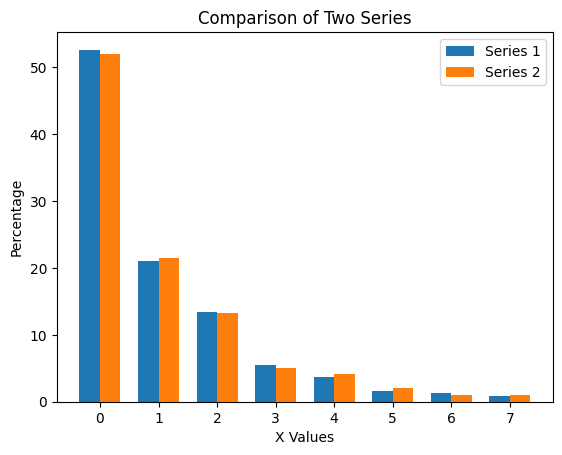

In [88]:
import numpy as np
import matplotlib.pyplot as plt

s1, s2 = np.array(y_train.value_counts().values), np.array(y_val.value_counts().values)
x = np.arange(max(set(y_val)) + 1)
s1p, s2p = (s1 / s1.sum()) * 100, (s2 / s2.sum()) * 100
bw = 0.35

fig, ax = plt.subplots()
ax.bar(x - bw/2, s1p, bw, label='Series 1')
ax.bar(x + bw/2, s2p, bw, label='Series 2')
ax.set_xlabel('X Values'); ax.set_ylabel('Percentage')
ax.set_title('Comparison of Two Series')
ax.set_xticks(x); ax.set_xticklabels(x); ax.legend()
plt.show()


## Train-Val Data processing

In [209]:
from pprint import pprint
training_data = []

system_message = """
    Sei un chatbot gentile che risponde ai clienti di UNK per assisterli sui suoi prodotti.
    Per rispondere, utilizza le seguenti coppie di domande e risposte fatte dai clienti algi assistenti che lavorano per l'azienda UNK.
    Sii il più specifico possibile, fornisci links e/o numero di telefono se necessario.
    Se non trovi una risposta specifica vai sul sito ufficiale "https://www.UNK.it/it/" e cerca il prodotto che viene richiesto, fornendo il link completo al cliente.
    Se la domanda/affermazione fa emergere delle complicanze rispondi scusandoti ed invitando a contattare il servizio clienti al
    Numero Verde 800124535 o all'indirizzo e-mail info@UNK.it".
    Se hai a disposizione molte informazioni, preferisci rispondere basandoti sulla data più recente, ed inizia la frase senza inserire la data.
    Se la domanda non riguarda i prodotti UNK rispondi 'Non trovo una risposta, puoi essere più specifico?'
    """

def prepare_example_conversation(row):
    messages = []
    messages.append({"role": "system",
                     "content": "Sei un chatbot gentile che risponde ai clienti di UNK per assisterli sui suoi prodotti."})

    #user_message = create_user_message(row)
    messages.append({"role": "user",
                     "content": row["Testo"]})

    messages.append({"role": "assistant",
                     "content": str(row["Data"]) + ": " + row["Risposta"]})

    return {"messages": messages}

In [ ]:
# Formatting for OPEN-AI FT engine
train_data = X_train.apply(prepare_example_conversation, axis=1).to_list()
validation_data = X_val.apply(prepare_example_conversation, axis=1).tolist()

print(len(train_data), len(validation_data))
train_data[0]

In [146]:
import json

def write_jsonl(data_list: list, filename: str) -> None:
    with open(filename, "w") as out:
        for ddict in data_list:
            jout = json.dumps(ddict) + "\n"
            out.write(jout)

training_file_name = "training_ft_date.jsonl"
write_jsonl(train_data, training_file_name)

validation_file_name = "validation_ft_date.jsonl"
write_jsonl(validation_data, validation_file_name)

In [147]:
training_response = openai.File.create(
    file=open(training_file_name, "rb"), purpose="fine-tune"
)

validation_response = openai.File.create(
    file=open(validation_file_name, "rb"), purpose="fine-tune"
)

training_file_id = training_response["id"]
validation_file_id = validation_response["id"]

print("Training file ID:", training_file_id)
print("Validation file ID:", validation_file_id)

Training file ID: file-s3iF6Sg15xsih2NG4pzlSYf7
Validation file ID: file-C71cmLzG0NOIM6slRnfRhTEA


## FineTuning

In [ ]:
response = openai.FineTuningJob.create(
    training_file=training_file_id,
    validation_file=validation_file_id,
    model="gpt-3.5-turbo",
    suffix="UNK_FT_2",
)

job_id = response["id"]

print("Job ID:", response["id"])
print("Status:", response["status"])

In [ ]:
response = openai.FineTuningJob.retrieve(job_id)

print("Job ID:", response["id"])
print("Status:", response["status"])
print("Trained Tokens:", response["trained_tokens"])

In [ ]:
#1st fine-tuned model created: ft:gpt-3.5-turbo-0613:UNK:UNK-ft:8G9cCh9V
#2nd fine-tuned model created: ft:gpt-3.5-turbo-0613:UNK:UNK-ft-2:8GAqmpJf

In [ ]:
response = openai.FineTuningJob.list_events(id=job_id, limit=50)

events = response["data"]
events.reverse()

for event in events:
    print(event["message"])

### Comparison

In [ ]:
ask(t4, print_message=True)

In [ ]:
response = openai.FineTuningJob.retrieve(job_id)
fine_tuned_model_id = response["fine_tuned_model"]

model1 = "ft:gpt-3.5-turbo-0613:UNK:UNK-ft:8G9cCh9V"
model2 = "ft:gpt-3.5-turbo-0613:UNK:UNK-ft-2:8GAqmpJf"

test_messages = []
test_messages.append({"role": "system", "content": "Sei un chatbot gentile che risponde ai clienti di UNK per assisterli sui suoi prodotti."})
test_messages.append({"role": "user", "content": system_message + "\n" + t4})

response = openai.ChatCompletion.create(
    model=model1,
    messages=test_messages,
    temperature=0,
    max_tokens=500
)

print(response["choices"][0]["message"]["content"])

In [ ]:
# List 10 fine-tuning jobs
openai.FineTuningJob.list(limit=10)